In [192]:
import io
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import nbformat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


nb = nbformat.read("Lab2_PCA-Reg.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 422


## PCA


 component: 1 =  [0.31492694], sum of variance: 0.31492694122402626

 component: 2 =  [0.31492694 0.17340667], sum of variance: 0.4883336138359774

 component: 4 =  [0.31492694 0.17340667 0.10378359 0.09727967], sum of variance: 0.6893968756336044

 component: 6 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747], sum of variance: 0.8015050286030233

 component: 8 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465], sum of variance: 0.8647711612598442

 component: 10 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0.02272241 0.02008611], sum of variance: 0.9075796829492933

 component: 13 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0.02272241 0.02008611 0.0177196  0.01377721
 0.01248948], sum of variance: 0.9515659748833728

 component: 15 =  [0.31492694 0.17340667 0.10378359 0.09727967 0.06490068 0.04720747
 0.03281148 0.03045465 0

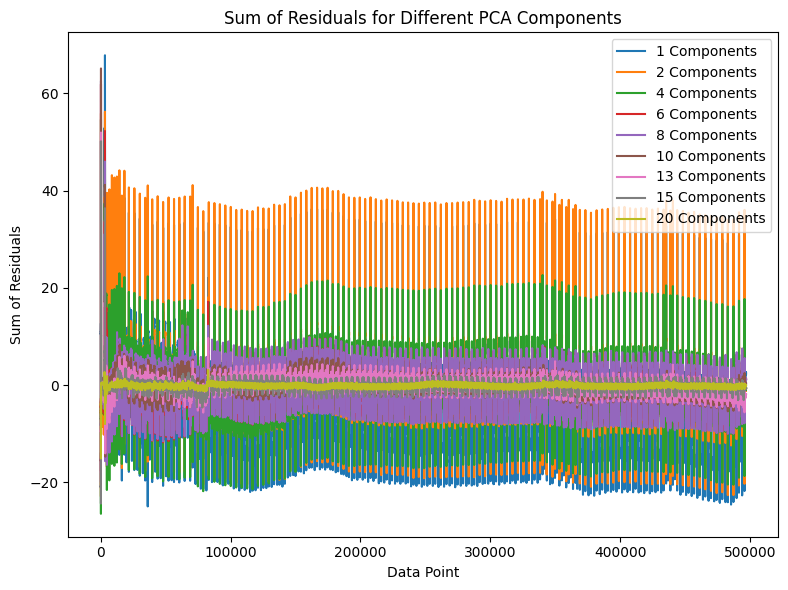

In [177]:
# read the test data
df2 = pd.read_csv("train_data.csv")
df2.drop(['Id', 'Timestamp', 'Label'], axis=1, inplace=True)

scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2)

# Perform PCA with varying number of components
num_components = [1, 2, 4, 6, 8, 10, 13, 15, 20]  # Specify the desired number of components
residuals_sum_list = []

for n in num_components:
    pca = PCA(n_components=n)
    pca.fit(df2_scaled)
    df2_pca = pca.transform(df2_scaled)
    df2_reconstructed = pca.inverse_transform(df2_pca)
    residuals = df2_scaled - df2_reconstructed
    residuals_sum = residuals.sum(axis=1)  # Calculate sum of residuals for each data point
    residuals_sum_list.append(residuals_sum)
    print(f'\n component: {n} =  {pca.explained_variance_ratio_}, sum of variance: {sum(pca.explained_variance_ratio_)}')

# Plot the residuals for different number of components using snslineplot
plt.figure(figsize=(8, 6))

for i, residuals_sum in enumerate(residuals_sum_list):
    plt.plot(range(len(residuals_sum)), residuals_sum, linestyle='-', label=f'{num_components[i]} Components')

plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title('Sum of Residuals for Different PCA Components')
plt.legend()
plt.tight_layout()
plt.show()


15 components captures at-least 95% variance, providing a balance between information retention and model simplicity. Further components add little explained variance but increase model complexity and risk significant overfitting. Therefore, 15 components is a suitable choice, optimizing the variance and complexity.

In [178]:
data_train = "train_data.csv"
data_val = "val_data.csv"
train_df = pd.read_csv(data_train)
val_df = pd.read_csv(data_val)
original_train = train_df.copy()
original_val = val_df.copy()

train_df = train_df.drop(['Id', 'Timestamp'], axis=1)
val_df = val_df.drop(['Id', 'Timestamp'], axis=1)

# Standardize the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)

components = 15
pca = PCA(n_components=components)
pca.fit(train_df_scaled)
train_df_pca = pca.transform(train_df_scaled)
val_df_pca = pca.transform(val_df_scaled)

df_principal = pd.DataFrame(data=train_df_pca)
# print(df_principal.head())

df_principal_val = pd.DataFrame(data=val_df_pca)
# print(df_principal_val.head())

# reconstruct the data
df_reconstructed = pca.inverse_transform(train_df_pca)
df_reconstructed = pd.DataFrame(data=df_reconstructed, columns=train_df.columns)

df_reconstructed_val = pca.inverse_transform(val_df_pca)
df_reconstructed_val = pd.DataFrame(data=df_reconstructed_val, columns=val_df.columns)

# calculate the difference between the original data and the reconstructed data
residuals = train_df_scaled - df_reconstructed
# display(residuals)

residuals_val = val_df_scaled - df_reconstructed_val
# display(residuals_val)

In [179]:
# plot the sum of the residuals for components = 6 
summed_residuals = residuals.sum(axis=1)
summed_residuals_val = residuals_val.sum(axis=1)
residuals_val_label_1 = residuals_val[residuals_val['Label'] == 1]

# change values of labels from 1 to 10 for residuals_val for visibility purposes
residuals_val_label_1['Label'] = 10

/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_60288/1070709568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_val_label_1['Label'] = 10


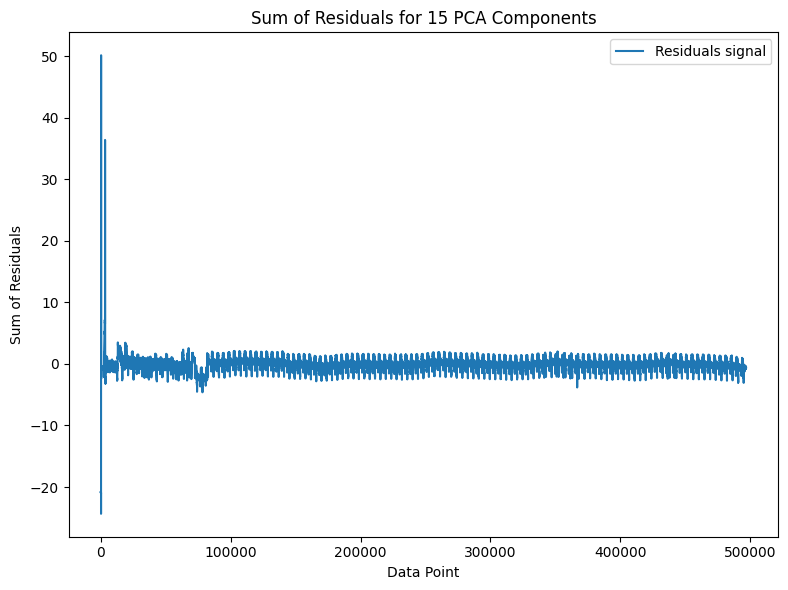

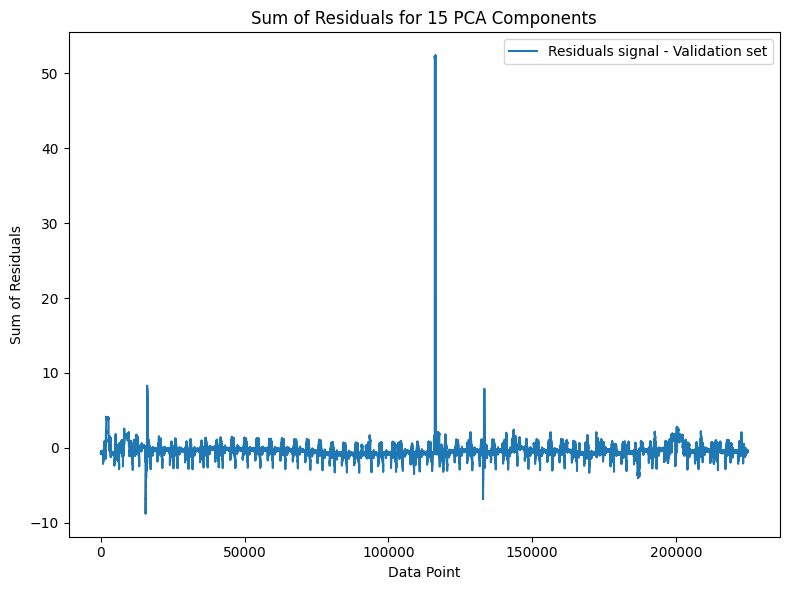

In [180]:
# we now plot the residuals of the validation set and the residuals of the training set

plt.figure(figsize=(8, 6))
plt.plot(summed_residuals.index, summed_residuals.values, linestyle='-', label=f'Residuals signal')
plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(summed_residuals_val.index, summed_residuals_val.values, linestyle='-', label=f'Residuals signal - Validation set')
plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_60288/703531001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_val_label_1['Label'] = 10


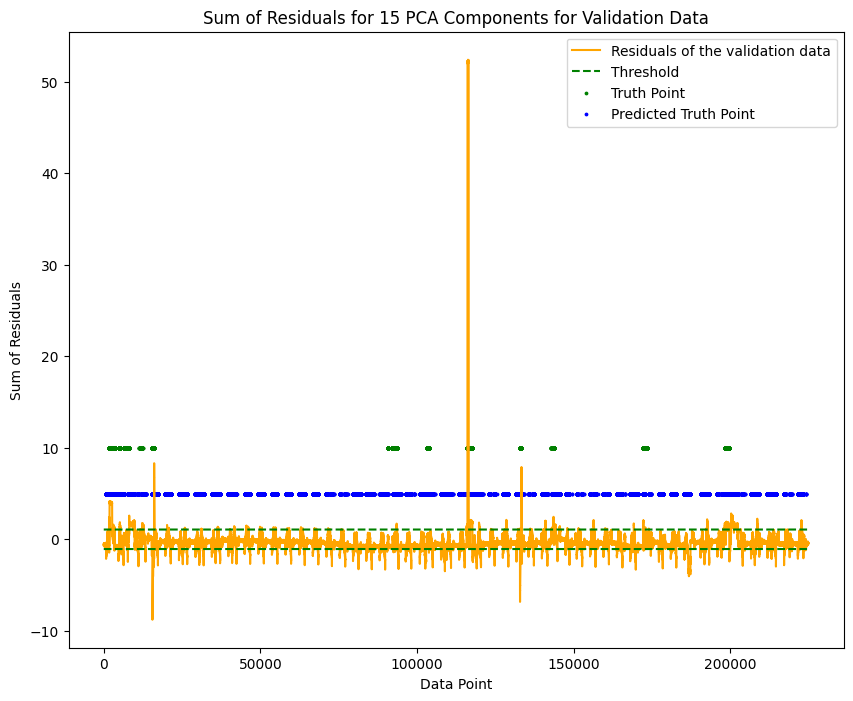

In [181]:
# plot the sum of the residuals for components = 6 
summed_residuals_val = residuals_val.sum(axis=1)
residuals_val_label_1 = residuals_val[residuals_val['Label'] == 1]
residuals_val_label_1['Label'] = 10

# set the threshold for residuals as 95% of the variance
quantile_val = 0.95
threshold_val = residuals_val.sum(axis=1).quantile(quantile_val)
negative_threshold_val = -threshold_val  # new negative threshold

# add label 5 to summed_residuals_val if it is anomalous and 0 if it is not
# and label -5 if it is below the negative threshold
summed_residuals_val_label = summed_residuals_val.copy()
summed_residuals_val_label[summed_residuals_val_label > threshold_val] = 5
summed_residuals_val_label[summed_residuals_val_label <= negative_threshold_val] = 5
summed_residuals_val_label[(summed_residuals_val_label > negative_threshold_val) & (summed_residuals_val_label <= threshold_val)] = 0

plt.figure(figsize=(10, 8))

# calculate the threshold lines
threshold_line = np.full(len(summed_residuals_val), threshold_val)
negative_threshold_line = np.full(len(summed_residuals_val), negative_threshold_val)

# plot the sum of residuals for all data
plt.plot(summed_residuals_val.index, summed_residuals_val.values, color='orange', label='Residuals of the validation data')

# plot threshold lines
plt.plot(summed_residuals_val.index, threshold_line, color='g', linestyle='--', label='Threshold')
plt.plot(summed_residuals_val.index, negative_threshold_line, color='g', linestyle='--',)

# plot truth points and predicted truth points
plt.scatter(residuals_val_label_1['Label'].index, residuals_val_label_1['Label'].values, s=3, color='g', label='Truth Point')
plt.scatter(summed_residuals_val_label[summed_residuals_val_label == 5].index, summed_residuals_val_label[summed_residuals_val_label == 5].values, s=3, color='b', label='Predicted Truth Point')

plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components for Validation Data')
plt.legend()
plt.show()


In [189]:
# calculate f1 score of the validation set
f1_score_result = f1_score(original_val['Label'], summed_residuals_val_label, average='weighted')
print(f1_score_result)

0.8682901335377029


In [183]:
# remove anomalies and redo PCA 
summed_residuals = residuals.sum(axis=1)

quantile = 0.95
threshold = residuals.sum(axis=1).quantile(quantile)
negative_threshold_val = -threshold 

# remove the data points that are above the negative threshold and below the threshold from original_train
print(len(original_train))
original_train_clean = original_train[np.abs(summed_residuals) <= threshold]
print(len(original_train_clean))

496800
444295


In [184]:
train_df = original_train_clean.drop(['Id', 'Timestamp'], axis=1)
val_df = original_val.copy().drop(['Id', 'Timestamp'], axis=1)

# Standardize the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)

components = 15
pca = PCA(n_components=components)
pca.fit(train_df_scaled)
val_df_pca = pca.transform(val_df_scaled)

df_principal_val = pd.DataFrame(data=val_df_pca)

# reconstruct the data
df_reconstructed_val = pca.inverse_transform(val_df_pca)
df_reconstructed_val = pd.DataFrame(data=df_reconstructed_val, columns=val_df.columns)

# calculate the difference between the original data and the reconstructed data
residuals_val_clean = val_df_scaled - df_reconstructed_val

/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_60288/934234377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_val_label_1['Label'] = 10


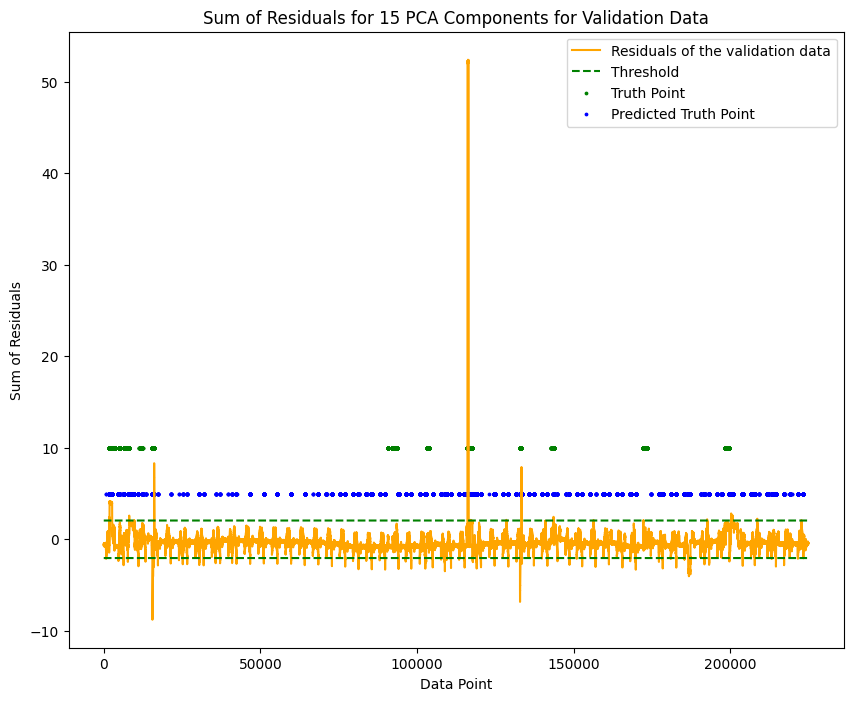

In [185]:
# plot the sum of the residuals for components = 6 
summed_residuals_val_clean = residuals_val_clean.sum(axis=1)
residuals_val_label_1 = residuals_val_clean[residuals_val_clean['Label'] == 1]
residuals_val_label_1['Label'] = 10

# set the threshold for residuals as 95% of the variance
quantile_val = 0.99
threshold_val = residuals_val.sum(axis=1).quantile(quantile_val)
negative_threshold_val = -threshold_val  # new negative threshold

# add label 5 to summed_residuals_val if it is anomalous and 0 if it is not
# and label -5 if it is below the negative threshold
summed_residuals_val_label_clean = summed_residuals_val_clean.copy()
summed_residuals_val_label_clean[summed_residuals_val_label_clean > threshold_val] = 5
summed_residuals_val_label_clean[summed_residuals_val_label_clean <= negative_threshold_val] = 5
summed_residuals_val_label_clean[(summed_residuals_val_label_clean > negative_threshold_val) & (summed_residuals_val_label_clean <= threshold_val)] = 0

plt.figure(figsize=(10, 8))

# calculate the threshold lines
threshold_line = np.full(len(summed_residuals_val), threshold_val)
negative_threshold_line = np.full(len(summed_residuals_val), negative_threshold_val)

# plot the sum of residuals for all data
plt.plot(summed_residuals_val.index, summed_residuals_val.values, color='orange', label='Residuals of the validation data')

# plot threshold lines
plt.plot(summed_residuals_val.index, threshold_line, color='g', linestyle='--', label='Threshold')
plt.plot(summed_residuals_val.index, negative_threshold_line, color='g', linestyle='--',)

# plot truth points and predicted truth points
plt.scatter(residuals_val_label_1['Label'].index, residuals_val_label_1['Label'].values, s=3, color='g', label='Truth Point')
plt.scatter(summed_residuals_val_label_clean[summed_residuals_val_label_clean == 5].index, summed_residuals_val_label_clean[summed_residuals_val_label_clean == 5].values, s=3, color='b', label='Predicted Truth Point')

plt.xlabel('Data Point')
plt.ylabel('Sum of Residuals')
plt.title(f'Sum of Residuals for {components} PCA Components for Validation Data')
plt.legend()
plt.show()


In [191]:
f1_score_result = f1_score(val_df['Label'], summed_residuals_val_label_clean, average='weighted')
print(f1_score_result)

0.9111059011185098


In the training and validation set we do see large abnormalities which is caused because of anomalous data. When PCA is applied, it attempts to fit the maximum variance in the data along the principal components, considering the majority of the data points. When an anomaly is present, the residual associated with this data point tends to be larger because the PCA cannot adequately represent this abnormal data point. This increased deviation represented in the residuals can help identify the anomaly as it significantly deviates from the typical residual distribution. After anomaly removal, we reapplied PCA to the training data, improving the model's F1 score when tested on the validation set.


Typically, PCA is primarily used for detecting point anomalies, as these individual instances deviate significantly from the majority of data points. This is achieved through dimensionality reduction, where large residuals indicate potential anomalies. 

## Regression

### PACF

In [193]:
# make sure you have the following installed so that it can run the pacf function
# !pip install statsmodels

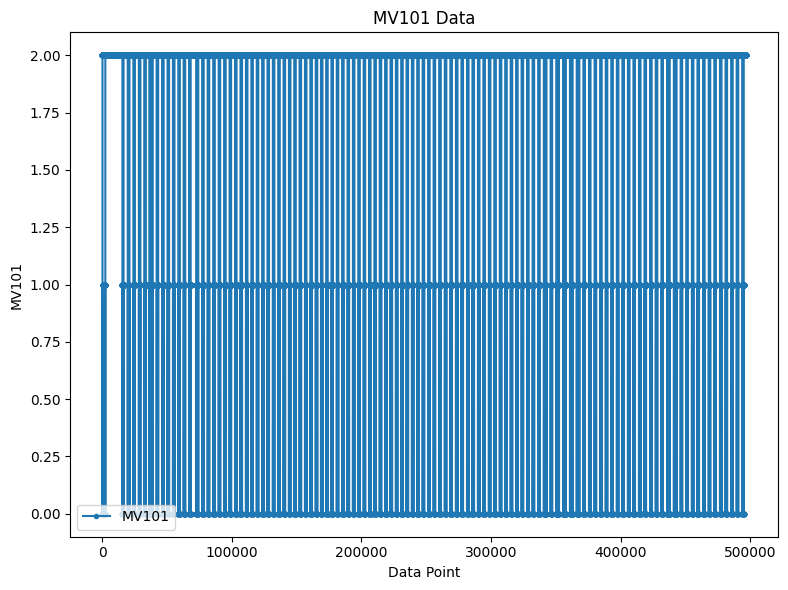

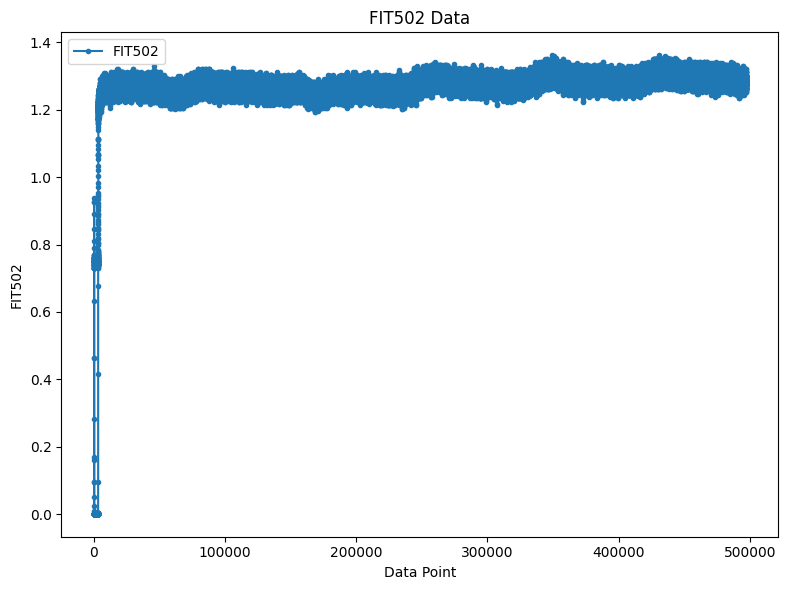

In [39]:
df_arma = pd.read_csv('train_data.csv')
df_arma_val = pd.read_csv('val_data.csv')

# plot AIT203 data over all the data points
plt.figure(figsize=(8, 6))
plt.plot(df_arma.index, df_arma['MV101'].values, marker='.', linestyle='-', label='MV101')
plt.xlabel('Data Point')
plt.ylabel('MV101')
plt.title('MV101 Data')
plt.legend()
plt.tight_layout()
plt.show()

# plot FIT502 data over all the data points
plt.figure(figsize=(8, 6))
plt.plot(df_arma.index, df_arma['FIT502'].values, marker='.', linestyle='-', label='FIT502')
plt.xlabel('Data Point')
plt.ylabel('FIT502')
plt.title('FIT502 Data')
plt.legend()
plt.tight_layout()
plt.show()

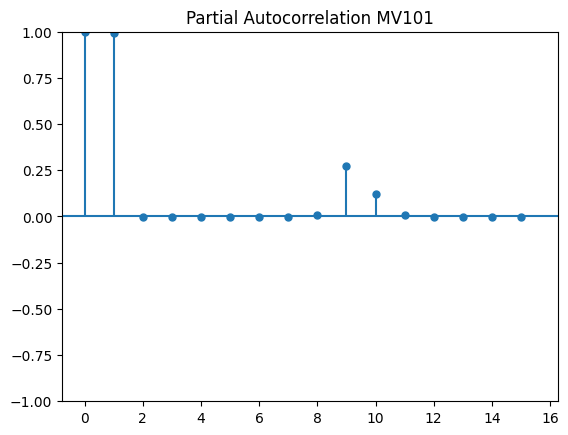

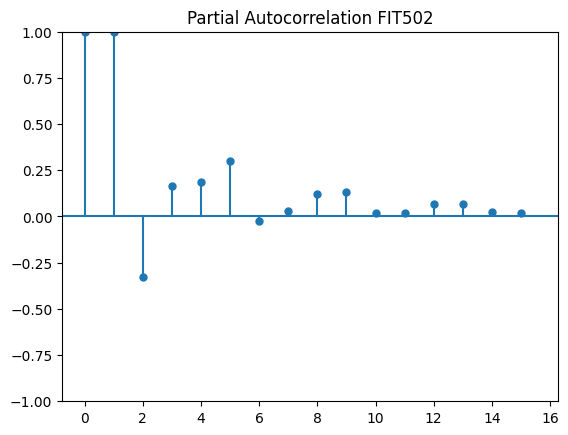

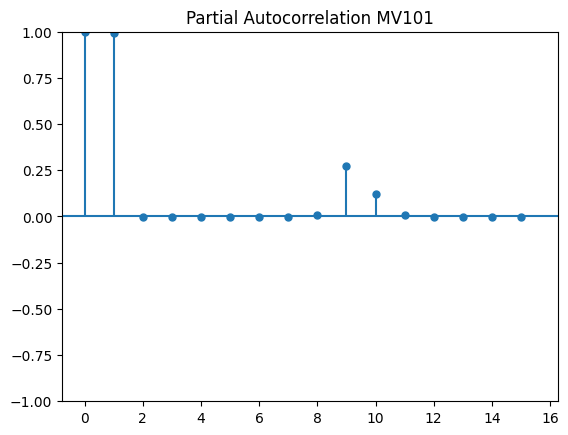

In [56]:
from statsmodels.graphics.tsaplots import plot_pacf

# partial autocorrelation plot for FIT502
signal = 'FIT502'
signal2 = 'MV101'

plot_pacf(df_arma[signal], lags=15, method='ywm', title= f'Partial Autocorrelation {signal}')
plot_pacf(df_arma[signal2], lags=15, method='ywm', title= f'Partial Autocorrelation {signal2}')

Sliding window lengths from 3-5 as for FIT502

### Autoregression

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

signal = df_arma['FIT502']
differenced_signal = signal.diff().dropna()

# Sliding windows of lengths 3, 4, 5

def sliding_windows2(signal, validation_signal=None):
    window_sizes = [3,4,5]

    predictions_list = []
    actual_list = []

    # loop through the window sizes
    for window_size in window_sizes:
        # Initialize lists to store the slopes and intercepts
        predictions = []

        # Loop through the signal and apply linear regression for each window
        for i in range(len(signal) - window_size):
            # Get the data points for the window
            y = signal[i : i + window_size]
            X = np.array(range(i, i + window_size)).reshape(-1, 1)

            # Fit a linear regression model to the data in the window
            model = LinearRegression().fit(X, y)

            # Use the model to make a prediction for the next data point
            next_X = np.array([[i + window_size]])
            prediction = model.predict(next_X)
            predictions.append(prediction[0])

        # Calculate the mean squared error of the predictions
        mse = mean_squared_error(signal[window_size:], predictions)

        predictions_list.append(predictions)
        actual_list.append(signal[window_size:])

        # Print the window size
        print(f"Window size: {window_size}")
        
        # Print the mean squared error
        print(f"Mean squared error: {mse}")

    return predictions_list, actual_list

In [63]:
# took around 8 min to run for 3 windows twice 

# function on non-differenced signal
non_differenced_predictions, non_differenced_actual = sliding_windows2(signal)

Window size: 3
Mean squared error: 0.00010501176823902715
Window size: 4
Mean squared error: 0.0001339504619021738
Window size: 5
Mean squared error: 0.0001717174867261961


The MSE results indicate that the model performs best when using a window size of 3, since it is smallest for this window size and tends to increase with larger window sizes. This agrees with the Autocorrelation analysis, which suggests significant autocorrelation at lags 1 and 2, and a decreasing autocorrelation from lag 3 onwards.

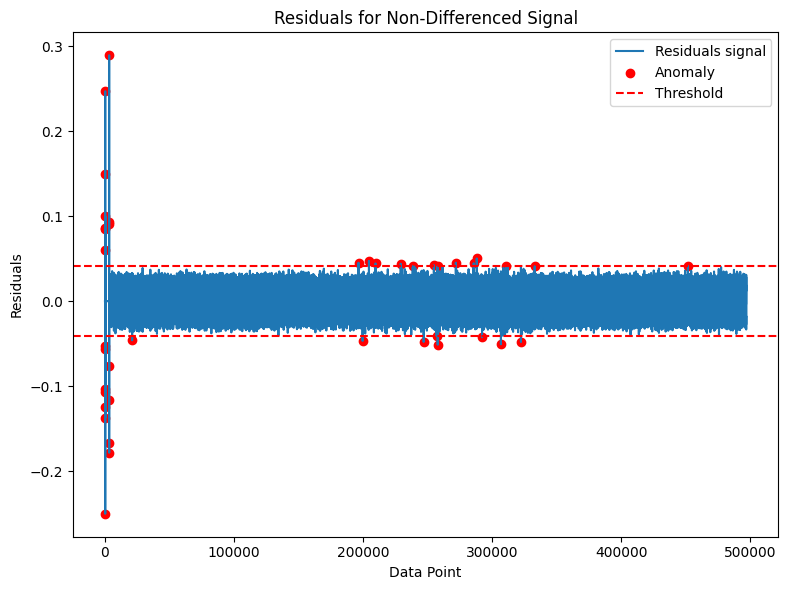

In [64]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = non_differenced_actual[0] - non_differenced_predictions[0]
threshold = 4 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


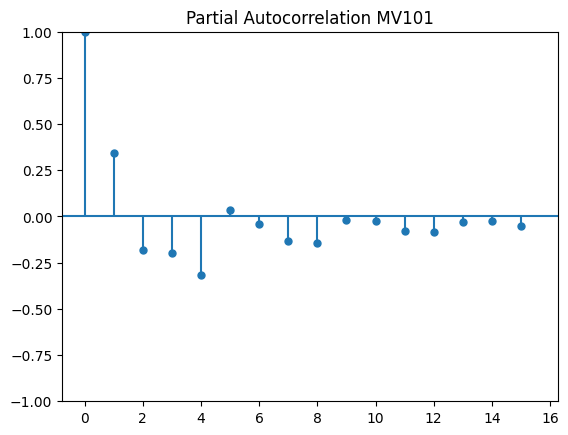

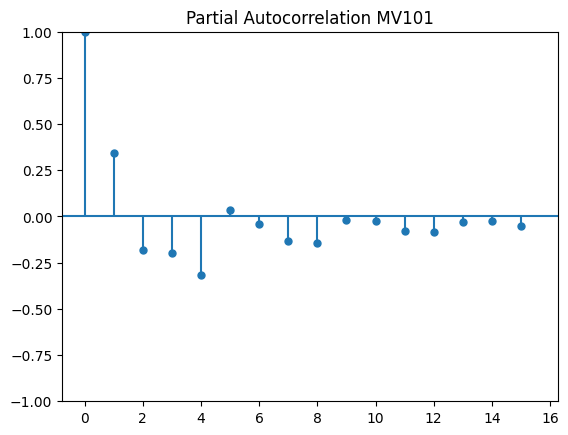

In [68]:
# pacf for differenced_signal
signal = df_arma['FIT502'].diff().dropna()
plot_pacf(signal, lags=15, method='ywm', title= f'Partial Autocorrelation {signal2}')

In [69]:
# function on differenced signal
diff_predictions, diff_actual = sliding_windows2(differenced_signal)

Window size: 3
Mean squared error: 0.00016049845219838236
Window size: 4
Mean squared error: 0.00014060345550328046
Window size: 5
Mean squared error: 0.0001524687075154747


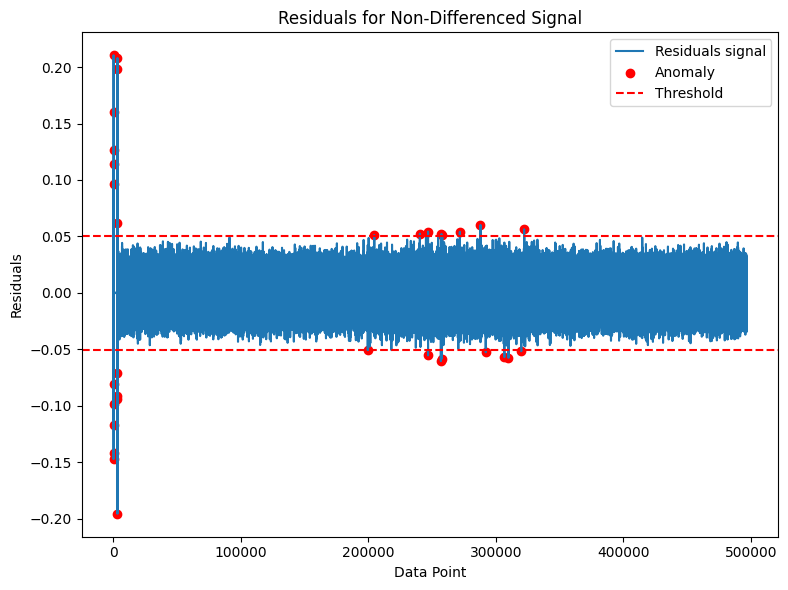

In [70]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = diff_predictions[0] - diff_actual[0]
threshold = 4 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


We can see from the MSE values that the differenced data also aggrees with the Autocorrelation, as for a lag of 3 it has the worst performance and has better performances for lag 4 and 5. We can see that for window 3 the MSE is the highest (worst) and is better as it increases.

In [71]:
# Autoregression on signal3 (MV101) with window size 3
signal3 = df_arma['MV101']
# variance of signal3
variance = np.var(signal3)
print(f"Variance: {variance}")
signal3_predictions, signal3_actual = sliding_windows2(signal3)

Variance: 0.21037695158434272
Window size: 3
Mean squared error: 0.003788714952423599
Window size: 4
Mean squared error: 0.0036534110580600486
Window size: 5
Mean squared error: 0.003750842903016704


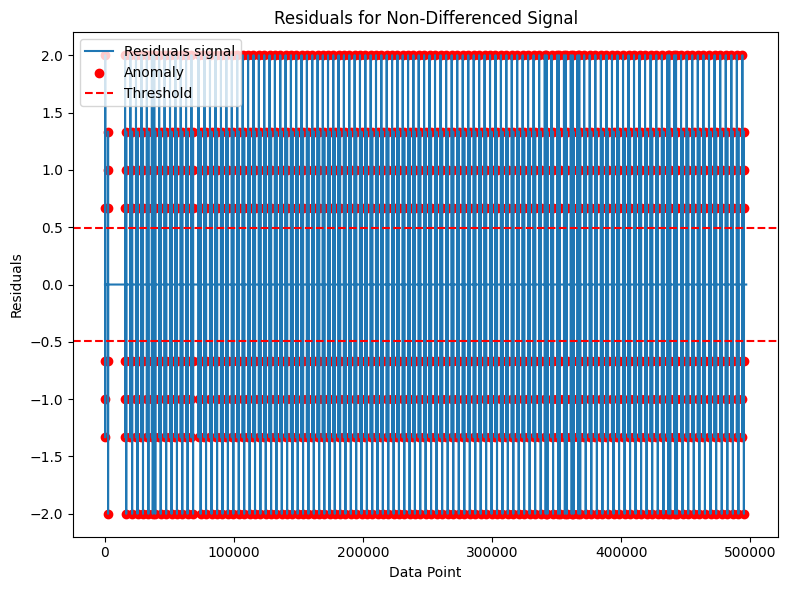

In [72]:
# calculate the residuals for the non-differenced signal for window size 3
residuals = signal3_predictions[0] - signal3_actual[0]
threshold = 8 * residuals.std()

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, np.sign(residuals) * 5, 0), index=residuals.index)

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index, residuals[labels != 0], color='r', label='Anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Non-Differenced Signal')
plt.legend()
plt.tight_layout()
plt.show()


### Analysis


Regression can detect point and contextual anomalies by predicting future values based on past ones. The difference between observed and predicted values, called residuals, can highlight anomalies. An unusually large residual might suggest a contextual anomaly, given it deviates from expected patterns based on the historical context.

We repeated the analysis on another signal, MV101 which did not perform well. From the plot above we can see that this signal has high cyclic behaviour. Regression works best on signals which are stationary, exhibit linear trends, and lack cyclic or seasonal patterns. It is not well-suited to signals with abrupt changes, long-term patterns or complete randomness. So regression is not good for this type of signal

In [ ]:
# Following is the analysis on the validation set which is also done in main notebook

In [73]:

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

df_train = pd.read_csv('train_data.csv', index_col=0)
df_val = pd.read_csv('val_data.csv', index_col=0)

signal = df_val['FIT502']

# sliding window of length 3
window_size = 3 

# initialize lists to store the slopes and intercepts
slopes = []
intercepts = []
predictions = []

# loop through the signal
for i in range(len(signal) - window_size):
    # Get the data points in the window
    X = np.array(range(window_size)).reshape(-1, 1)
    y = signal[i:i+window_size]

    # Apply linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Append the slope and intercept
    intercepts.append(model.intercept_)
    slopes.append(model.coef_[0])

    # Make a prediction for the next data point
    next_point_prediction = model.predict(np.array([[window_size]]))
    predictions.append(next_point_prediction[0])

# calculate the mean squared error of the predictions
mse = mean_squared_error(signal[window_size:], predictions)

# print the mean squared error
print(f"Mean squared error: {mse}")


Mean squared error: 0.00010891786270360677


/var/folders/f5/pgcxx91x31l672vfgh983wcr0000gn/T/ipykernel_60288/3997562249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_actual['Label'] = 0.09


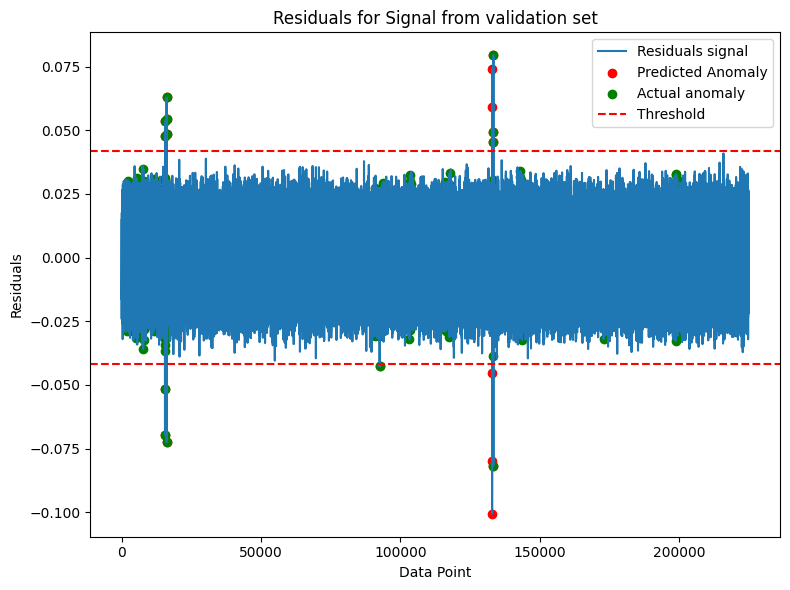

In [74]:
# get the residuals
residuals = signal[window_size:] - predictions

threshold = 4 * np.std(residuals)

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, 0.08, 0), index=residuals.index)

# get labels from signal
labels_actual = df_val[df_val['Label']==1]
labels_actual['Label'] = 0.09

# get index of actual labels where label is not zero
actual_labels_index = labels_actual[labels_actual['Label'] != 0].index

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')

plt.scatter(labels[labels != 0].index, residuals[labels != 0].values, color='r',  label='Predicted Anomaly')
plt.scatter(actual_labels_index, residuals[actual_labels_index].values, color='g', label='Actual anomaly')

plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Signal from validation set')
plt.legend()
plt.tight_layout()
plt.show()


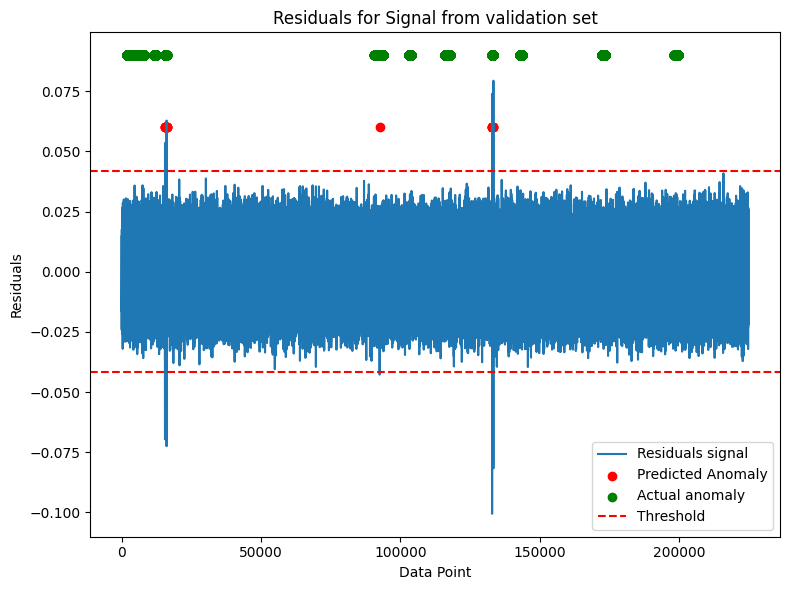

In [75]:
# get the residuals
residuals = signal[window_size:] - predictions

threshold = 4 * np.std(residuals)

# calculate labels for the residuals
labels = pd.Series(np.where(residuals.abs() > threshold, 0.08, 0), index=residuals.index)

# get labels from signal
labels_actual = df_val['Label']

# plot residuals and labels
plt.figure(figsize=(8, 6))
plt.plot(residuals, label='Residuals signal')
plt.scatter(labels[labels != 0].index,  [0.06 for i in range(len(residuals[labels != 0]))], color='r',  label='Predicted Anomaly')
plt.scatter(labels_actual[labels_actual != 0].index, [0.09]*len(labels_actual[labels_actual != 0]), color='g', label='Actual anomaly')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('Residuals')
plt.title('Residuals for Signal from validation set')
plt.legend()
plt.tight_layout()
plt.show()